In [8]:
import matplotlib as mpl
import numpy as np
import scipy 
import pickle
import pylab as plt
import copy
import pandas as pd
from pathlib import Path
%matplotlib inline
import csv   
import ROOT

#### Script Description

This script takes in the MCeQ flux file and converts into a csv format
along with the bin edges.

In [9]:
# Load in the files
f=open("./MCEqFluxMeshes.pkl","rb")
EBins, cosas, bs, FluxMeshes= pickle.load(f)
f.close()

f=open("./LinInterps.pkl","rb")
LinInterps=pickle.load(f)
f.close()

LinInterps.keys()

/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_6983/21788174.py:7: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  LinInterps=pickle.load(f)


dict_keys([100, 300, 400, 450, 500, 550, 600, 650, 700, 800, 900, 1000, 2000, 4000, 6000])

In [10]:
eps=0.01
survivalfractions=[]
correctedmeshes=[]

for ei in range(0,len(EBins)-2):
    
    mesh=copy.copy(FluxMeshes[ei])
    survmesh=np.zeros_like(mesh)
    
    for ica in range(len(cosas)):
    
        for ib in range(len(bs)):
            surv=LinInterps[EBins[ei]](cosas[ica]+eps,bs[ib])
            survmesh[ica,ib]=surv
            mesh[ica,ib]=mesh[ica,ib]*surv
    
    correctedmeshes.append(mesh)
    survivalfractions.append(survmesh)

In [59]:
intensity = []
azimuth      = []
zenith     = []


cosa_mesh, b_mesh=np.meshgrid(cosas, bs)
zenith_=np.arccos(cosas-4e-16) # 4e-16 factor introduced to remove erroneous cosas > 1

totalflux=np.zeros_like(correctedmeshes[0])
for m in correctedmeshes:
    totalflux+=m

print(len(cosas), len(totalflux))

# Loop over the flux bins and get zenith and azimuth values to save to file
for y in range(0, len(totalflux)):
    for x in range(0, len(totalflux[y])):

        temp_az = bs[x]+np.pi+10*np.pi/180.0  # Add the extra 10 degrees so it aligns with the data
        temp_intensity = totalflux[y][x]

        if(temp_az > 2*np.pi): temp_az = temp_az - 2*np.pi

        if (zenith_[y] > 0 and bs[x]+np.pi > 0):
            intensity.append(temp_intensity)
            azimuth.append(temp_az)
            zenith.append(zenith_[y])

# Create a dictionary of the intensity, zenith and azimuth values to store
dict_ = {'Intensity':intensity, 'azimuth': azimuth, 'zenith': zenith}

# Dataframe from the dictionary
dataframe = pd.DataFrame(dict_)

# Write the data from hdf5 format to csv for reading into nexus
filepath = Path('SimulatedMuonsProposalMCEq.csv')  
dataframe.to_csv(filepath, index = False, header = False)  

# Save the bin edges to the file too

# Bin edges
binEdges_zenith_ = np.linspace(0.4, 1, 30)
binEdges_zenith_ = binEdges_zenith_[::-1]
binEdges_zenith = np.arccos(binEdges_zenith_)

binEdges_azimuth = np.linspace(0, 2*np.pi, 30)

with open(r'SimulatedMuonsProposalMCEq.csv', 'a') as f:
    writer = csv.writer(f)
    
    # Write the zenith bin edges
    for i in range(len(binEdges_zenith)):
        writer.writerow(['zenith', binEdges_zenith[i]])

    # Write the zenith bin edges
    for i in range(len(binEdges_azimuth)):
        writer.writerow(['azimuth',binEdges_azimuth[i]])


31 31
0.17453292519943295
0.3911944875159705
0.6078560498325081
0.8245176121490456
1.0411791744655827
1.2578407367821203
1.4745022990986578
1.6911638614151951
1.9078254237317327
2.1244869860482702
2.3411485483648073
2.557810110681345
2.7744716729978824
2.99113323531442
3.207794797630957
3.4244563599474946
3.641117922264032
3.8577794845805697
4.074441046897108
4.291102609213644
4.507764171530182
4.7244257338467195
4.941087296163257
5.157748858479795
5.374410420796332
5.59107198311287
5.807733545429407
6.024395107745944
6.241056670062481
6.457718232379019
0.17453292519943295
0.3911944875159705
0.6078560498325081
0.8245176121490456
1.0411791744655827
1.2578407367821203
1.4745022990986578
1.6911638614151951
1.9078254237317327
2.1244869860482702
2.3411485483648073
2.557810110681345
2.7744716729978824
2.99113323531442
3.207794797630957
3.4244563599474946
3.641117922264032
3.8577794845805697
4.074441046897108
4.291102609213644
4.507764171530182
4.7244257338467195
4.941087296163257
5.157748858

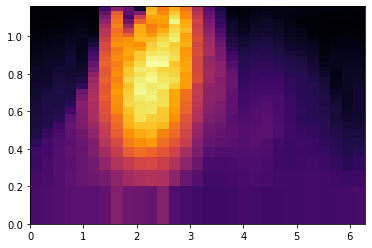

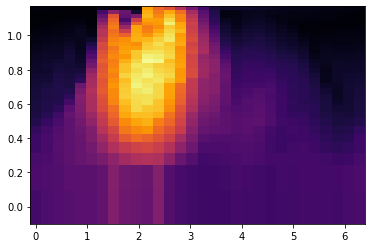

In [12]:
# Plot the histogram as a test
h, xedges, yedges, image = hist_data= plt.hist2d(dataframe["azimuth"], dataframe["zenith"], weights=dataframe["Intensity"], bins=[binEdges_azimuth, binEdges_zenith],cmap='inferno') 
plt.figure()
im=plt.pcolormesh(bs+np.pi,zenith_,totalflux,cmap='inferno',shading='auto',vmin=0,vmax=3e-7)

# print(np.random.rand(340,2)*5)
# print(im.get_array())

<class 'numpy.ndarray'>
[0.         0.20377142 0.28867933 0.35418047 0.40969745 0.45887421
 0.50357695 0.54491295 0.58360288 0.62014688 0.65490885 0.68816338
 0.72012373 0.75095952 0.78080832 0.80978357 0.83798017 0.86547849
 0.89234739 0.91864637 0.94442737 0.96973605 0.99461284 1.01909378
 1.04321123 1.06699434 1.09046959 1.11366109 1.13659094 1.15927948]


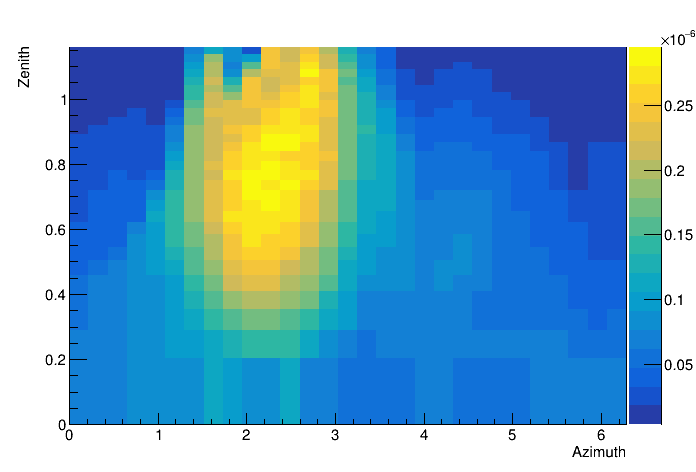

In [13]:
# Create a ROOT histogram
print(type(binEdges_azimuth))

# if (h != None): del h
h = ROOT.TH2F("za", ";Azimuth; Zenith", len(binEdges_azimuth)-1, binEdges_azimuth, len(binEdges_zenith)-1, binEdges_zenith)

print(binEdges_zenith)

for i in range(len(dataframe["azimuth"])):
    h.Fill(dataframe["azimuth"][i], dataframe["zenith"][i], dataframe["Intensity"][i])

ROOT.gStyle.SetOptStat(0)
c = ROOT.TCanvas()
h.Draw("COLZ")
c.Draw()

File = ROOT.TFile("SimulatedMuonFile.root", "RECREATE")
h.Write()
File.Close()


[0.         0.20377142 0.28867933 0.35418047 0.40969745 0.45887421
 0.50357695 0.54491295 0.58360288 0.62014688 0.65490885 0.68816338
 0.72012373 0.75095952 0.78080832 0.80978357 0.83798017 0.86547849
 0.89234739 0.91864637 0.94442737 0.96973605 0.99461284 1.01909378
 1.04321123 1.06699434 1.09046959 1.11366109 1.13659094 1.15927948]


Warning in <TROOT::Append>: Replacing existing TH1: za (Potential memory leak).
Error in <TView3D::FindPhiSectors>: something strange: num. of critical sector not equal 2
Error in <TView3D::FindPhiSectors>: something strange: num. of critical sector not equal 2


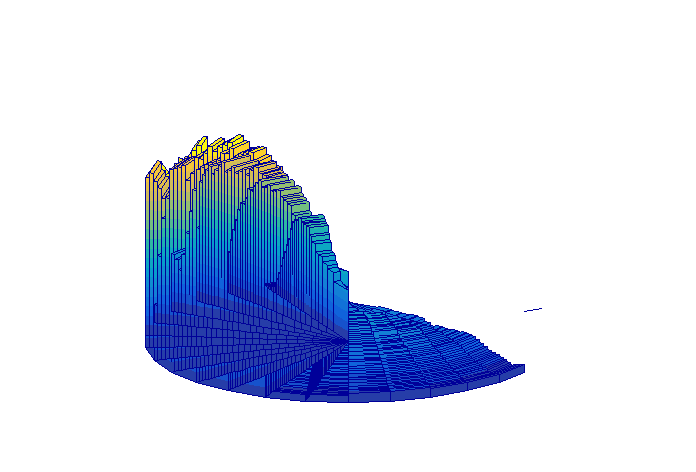

In [14]:
h = ROOT.TH2F("za", ";Azimuth; Zenith", 30, -np.pi, np.pi, len(binEdges_zenith)-1,binEdges_zenith-1.15927948/2)

print(binEdges_zenith)

for i in range(len(dataframe["azimuth"])):
    h.Fill(dataframe["azimuth"][i]-np.pi, dataframe["zenith"][i]-1.15927948/2, dataframe["Intensity"][i])

ROOT.gStyle.SetOptStat(0)
c = ROOT.TCanvas()
h.GetXaxis().SetRangeUser(-2,2)
h.Draw("LEGO2 POL")
c.Draw()

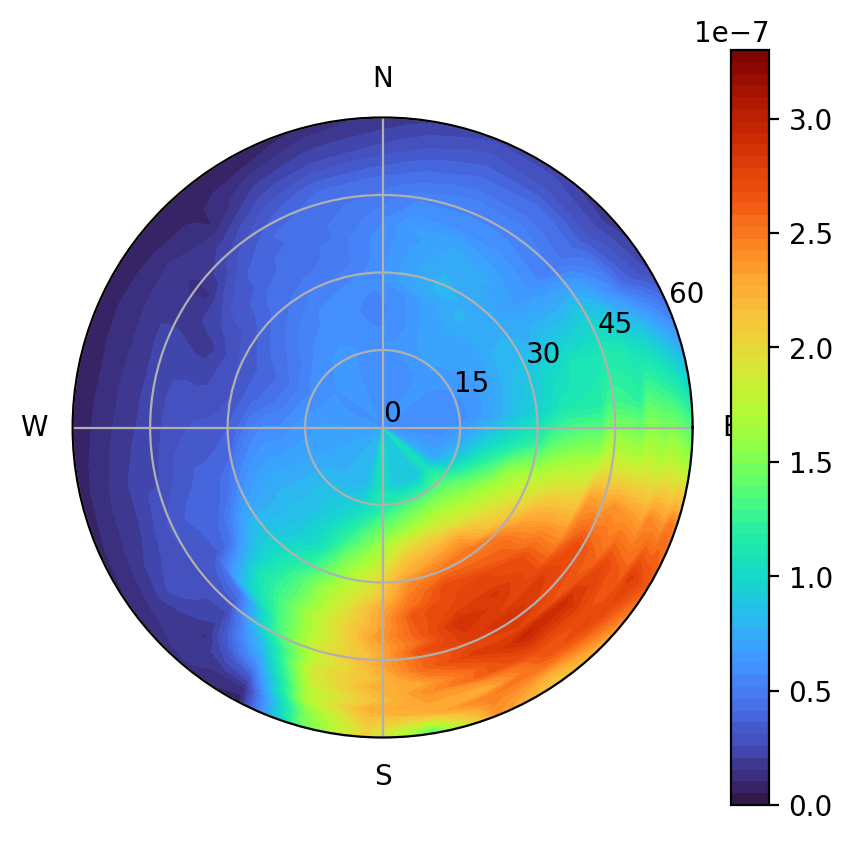

In [15]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'),figsize=(5,5),dpi=200)
fig.patch.set_facecolor('white')
levels=np.linspace(0,3.3e-7,65)
im=ax.contourf(bs, np.arccos(cosas-4e-16)*180/3.14, totalflux,cmap='turbo',levels=levels)
ax.set_rlim(0,60)
ax.set_rticks([0,15,30,45,60])
plt.colorbar(im,ticks=np.arange(0,3.5e-7,5e-8))
ax.set_thetagrids([0,90,180,270],['E','N','W','S'])
ax.set(facecolor = "lightgrey",alpha=0.2)
plt.show()

Text(0, 0.5, '$\\beta$')

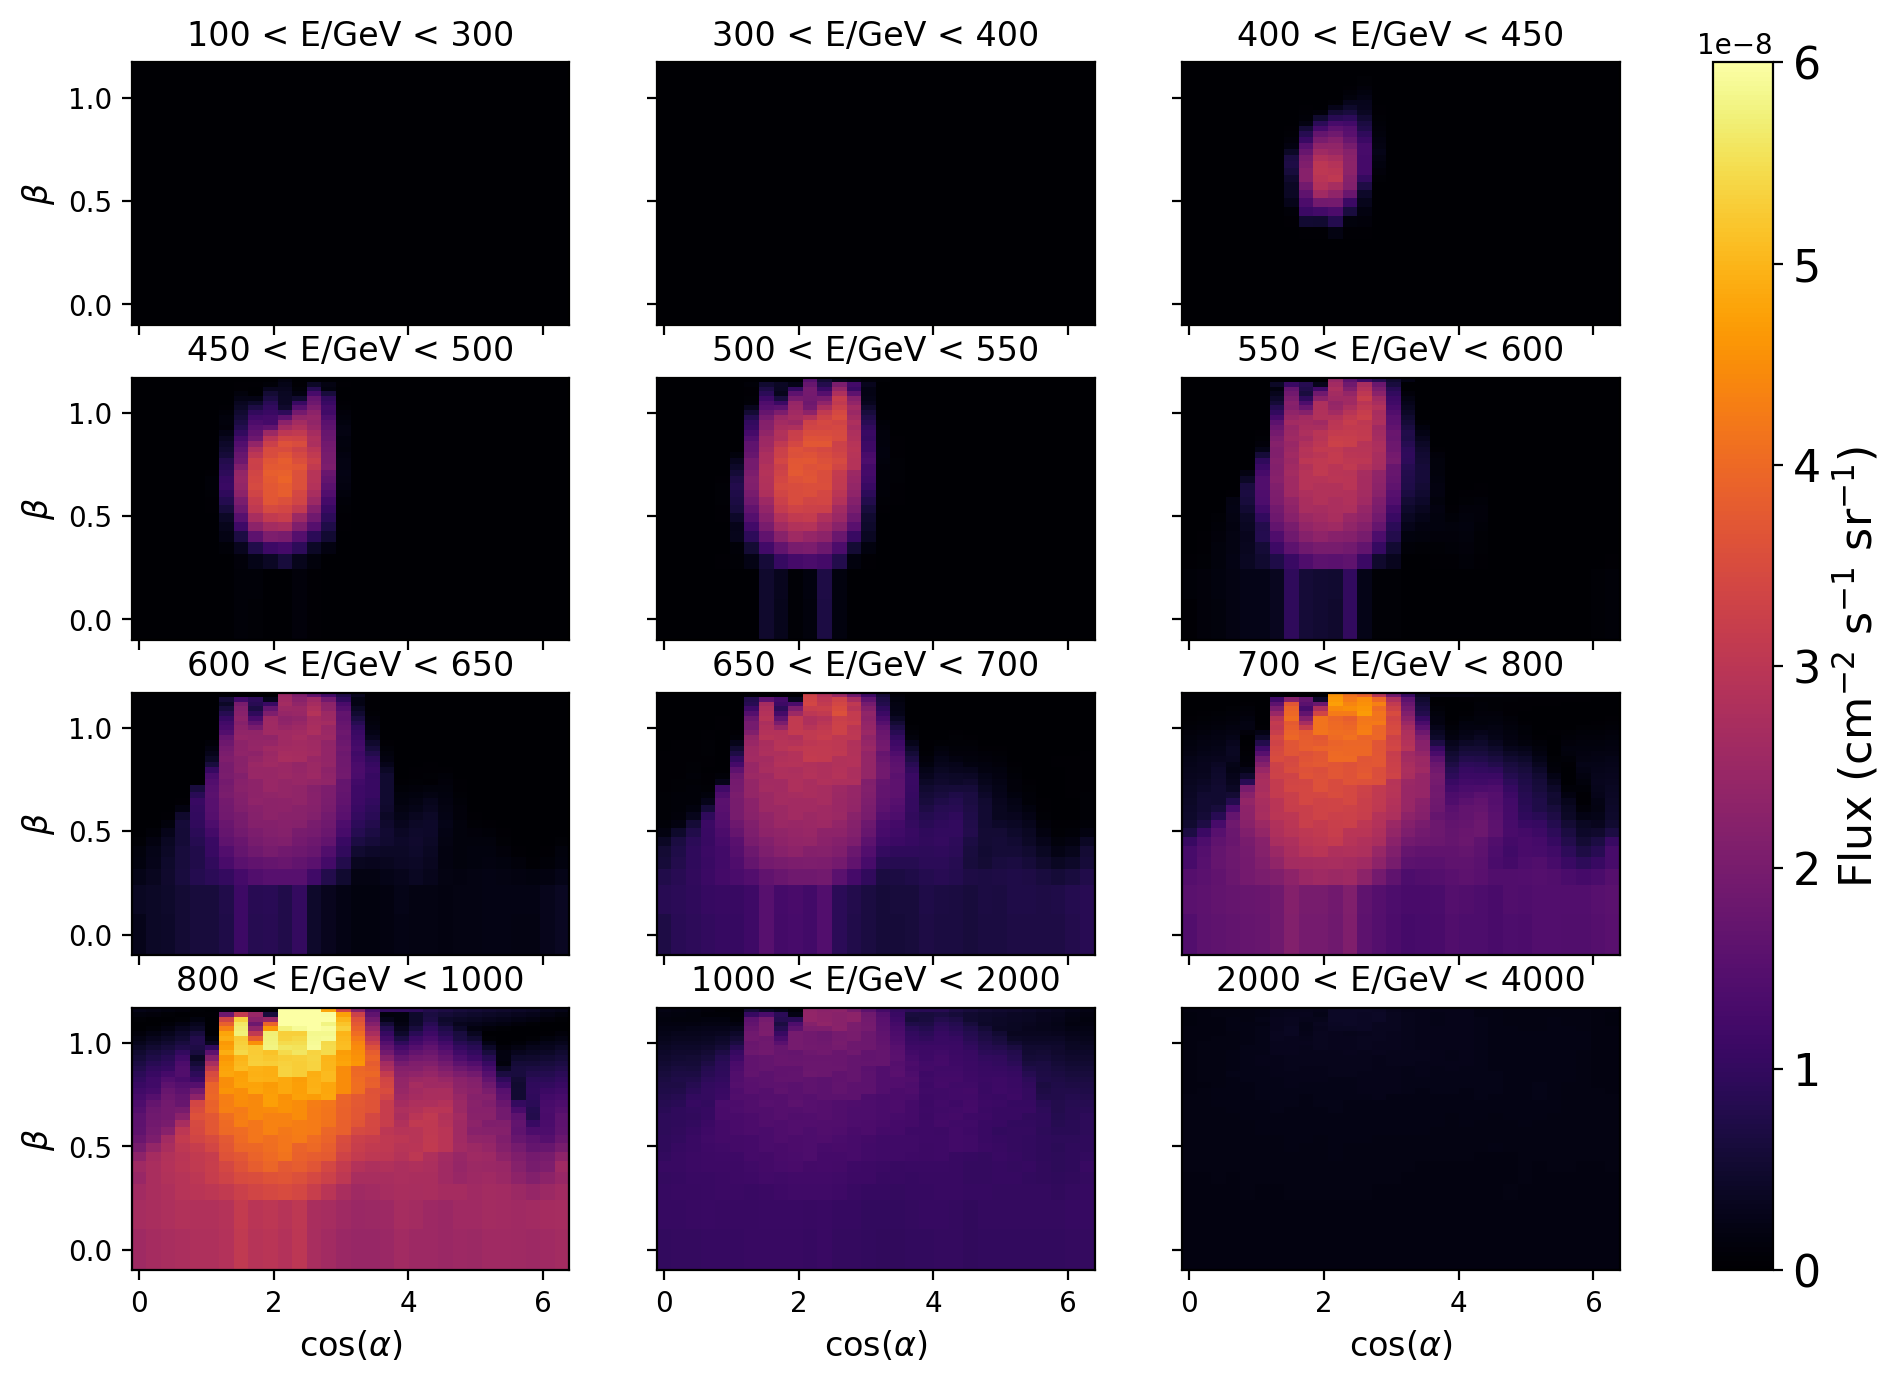

In [44]:
# Lets try and make a 3D histogram
# dict_keys([100, 300, 400, 450, 500, 550, 600, 650, 700, 800, 900, 1000, 2000, 4000, 6000])
startn=0
fig, axes = plt.subplots(nrows=4, ncols=3,figsize=(12,8),dpi=200, sharex=True, sharey=True)
for iax in range(0,len(axes.flat)):
    ax=axes.flatten()[iax]
    im=ax.pcolormesh(bs+np.pi,zenith_,correctedmeshes[iax+startn],cmap='inferno',shading='auto',vmin=0,vmax=6e-8)
    ax.set_title(str(EBins[iax+startn])+ " < E/GeV < " + str(EBins[iax+startn+1]))
    # ax.set_ylim(0,np.pi)
cbar=fig.colorbar(im, ax=axes.ravel().tolist(),label='Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
cbar.set_label('Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)',fontsize=16)
cbar.ax.tick_params(labelsize=16)

axes[3,0].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[3,1].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[3,2].set_xlabel(r"cos($\alpha$)",fontsize=12)

axes[0,0].set_ylabel(r"$\beta$",fontsize=12)
axes[1,0].set_ylabel(r"$\beta$",fontsize=12)
axes[2,0].set_ylabel(r"$\beta$",fontsize=12)
axes[3,0].set_ylabel(r"$\beta$",fontsize=12)

12 31 30


,flux,azimuth,zenith,energy
8700,1.828191e-09,0.391194,1.159279,1500.0
8701,1.559709e-09,0.607856,1.159279,1500.0
8702,1.159169e-09,0.824518,1.159279,1500.0
8703,6.495267e-10,1.041179,1.159279,1500.0
8704,2.389445e-10,1.257841,1.159279,1500.0
...,...,...,...,...
9565,1.015219e-08,5.591072,0.200335,1500.0
9566,1.015114e-08,5.807734,0.200335,1500.0
9567,1.026844e-08,6.024395,0.200335,1500.0
9568,1.035372e-08,6.241057,0.200335,1500.0


0.3911944875159705
0.3911944875159705
0.3911944875159705
0.3911944875159705
0.3911944875159705
0.3911944875159705
0.3911944875159705
0.3911944875159705
0.3911944875159705
0.3911944875159705
0.3911944875159705


Warning in <TROOT::Append>: Replacing existing TH1: za (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: za (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: za (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: za (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: za (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: za (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: za (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: za (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: za (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: za (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: za (Potential memory leak).


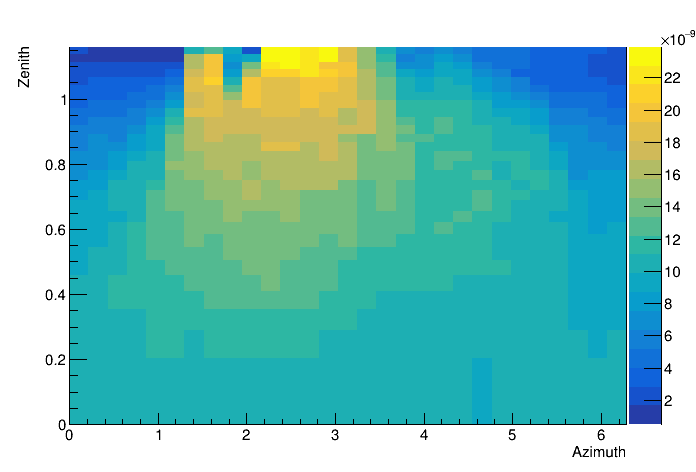

In [106]:
# Lets convert the 3D histogram into a dataframe

# Loop over the flux bins and get zenith and azimuth values to save to file

azimuth = []
zenith = []
energy = []
flux = []

# Loop over energy bins
print(len(correctedmeshes), len(correctedmeshes[0]), len(correctedmeshes[0][0]))
for e in range(0, len(correctedmeshes)):

    # Loop over the zenith = y
    for y in range(0, len(correctedmeshes[e])):
        
        # Loop over the azimuth - x
        for x in range(0, len(correctedmeshes[e][y])):

            temp_az = bs[x]+np.pi+10*np.pi/180.0  # Add the extra 10 degrees so it aligns with the data
            temp_intensity = correctedmeshes[e][y][x]

            if(temp_az > 2*np.pi): temp_az = temp_az - 2*np.pi

            if (zenith_[y] > 0 and bs[x]+np.pi > 0):
                flux.append(temp_intensity)
                azimuth.append(temp_az)
                zenith.append(zenith_[y])
                energy.append((EBins[e]+ EBins[e+1])/2.0)

# # Create a dictionary of the intensity, zenith and azimuth values to store
dict_ = {'flux':flux, 'azimuth': azimuth, 'zenith': zenith, 'energy': energy}

# # Dataframe from the dictionary
dataframe = pd.DataFrame(dict_)
# display(dataframe)


display(e3000)

for e in range(0, len(correctedmeshes)-1):

    # Make a cut on the dataframe
    e3000 = dataframe.loc[ (dataframe["energy"] == (EBins[e]+ EBins[e+1])/2.0)]

    h.Clear
    h = ROOT.TH2F("za", ";Azimuth; Zenith", len(binEdges_azimuth)-1, binEdges_azimuth, len(binEdges_zenith)-1, binEdges_zenith)

    # print(binEdges_zenith)

    print(e3000["azimuth"].iloc[0])

    for i in range(len(e3000["azimuth"])):
        h.Fill(e3000["azimuth"].iloc[i], e3000["zenith"].iloc[i], e3000["flux"].iloc[i])

    ROOT.gStyle.SetOptStat(0)
    c = ROOT.TCanvas()
    h.Draw("COLZ")
    c.Draw()

